# Clasificación de Sentimientos Utilizando LSTM Bidireccional

Realizado por:
- Paula Monge
- Emmanuel Zúñiga

Trabajo de Invetigación del Curso:
- Investigación en Ciencias de la Computación

Tema de Investigación:
- Aprendizaje Automático en la clasificación de Sentimientos en Twitter: Comparación de los Algoritmos de LSTM Bidireccional, BERT y Naïve Bayes

## Importación de librerias 📚

In [1]:
!pip install unidecode
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
from unidecode import unidecode
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

## Carga del dataset 📅

In [5]:
# Se carga la libreria drive de google para cargar los archivos almacenados en drive
drive.mount("/content/gdrive")

# El dataset en cuestión contiene datos sobre tweets en diferentes idiomas, pero nos interesa utilizar solo
# los que se encuentran en español.
tweets = pd.read_csv('/content/gdrive/My Drive/tweets.csv').query('Language == "es"')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
labels = {'Label': ['negative', 'positive', 'litigious', 'uncertainty']}
# Crear una instancia de LabelEncoder
le = LabelEncoder()

# Codificar la columna 'Label'
tweets['Label'] = le.fit_transform(tweets['Label'])

In [7]:
tweets.head(10)

,Text,Language,Label
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,1
36,"@alitomorenoc No mames, ya mejor lárgate del P...",es,0
173,"Good MEWning ♥️🐼♥️\nUn nuevo amanecer,un nuevo...",es,2
330,criminal por robarme el corazón https://t.co/O...,es,0
455,@isiupdates Pantera \n#IsiVives #IsiVivesCHILE...,es,2
556,Os quiero recordar y hacer saber a los que aún...,es,2
572,@Orlando71156528 Y sin embargo un criminal de ...,es,0
702,@Fergus0055 No sería porque los tóxicos de xbo...,es,2
812,@loonalendaskk ahh q legal,es,0
823,@JesusRCuevas @lopezobrador_ Pues no lamenta l...,es,0


## Preprocesamiento y limpieza de datos 🧹

In [8]:
def remove_emoji(string):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string) 

def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = unidecode(temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_ÑÁÉÍÓÚ]+","", temp)
    temp = re.sub("#","", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-zA-Z0-9ñáéíóú]"," ", temp)
    return temp
    
## Una vez creadas las funciones se procede a realizar la limpieza de los tweets
tweets['Text'] = tweets['Text'].map(lambda x : clean_tweet(x))

In [9]:
tweets.head()

,Text,Language,Label
1,badbunny como dos gotas de agua joven se dis...,es,1
36,no mames ya mejor largate del pri y deja de ...,es,0
173,good mewning un nuevo amanecer un nuevo dia u...,es,2
330,criminal por robarme el corazon,es,0
455,pantera isivives isiviveschile kcamexico,es,2


## Creación de sets de entrenamiento y prueba 📅

Para los datos de entrenamiento y prueba se utiliza una proporción de 80/20 con respecto al dataset original.

In [10]:
train_pct = 0.8
train_size = round(len(tweets) * train_pct)

train_data = tweets.iloc[:train_size]
test_data = tweets.iloc[train_size:]

test_data = test_data.drop('Label', axis=1)

In [11]:
train_data.head(10)

,Text,Language,Label
1,badbunny como dos gotas de agua joven se dis...,es,1
36,no mames ya mejor largate del pri y deja de ...,es,0
173,good mewning un nuevo amanecer un nuevo dia u...,es,2
330,criminal por robarme el corazon,es,0
455,pantera isivives isiviveschile kcamexico,es,2
556,os quiero recordar y hacer saber a los que aun...,es,2
572,y sin embargo un criminal de esa calana esta ...,es,0
702,no seria porque los toxicos de xbox y hasta s...,es,2
812,ahh q legal,es,0
823,pues no lamenta la muerte de miles de ninos ...,es,0


In [12]:
test_data.head(10)

,Text,Language
753287,1 si 2 maybe 3 no 4 yes 5 paque 6 obvi...,es
753312,somos lindos best,es
753315,en la carcel deberia estar este criminal la d...,es
753423,bad bunny no se equivoco cuando dijo el amor ...,es
753448,te amo question,es
753492,renovacion ha firmado un nuevo contrato de ...,es
753520,vuelvo a la depresion despues de amar y ser de...,es
753633,legal,es
753801,ojala que tuvieran una guerra ideologica con ...,es
753885,yo anhelo que las ffmm retornen su legitimida...,es


## Construcción del modelo - LSTM Bidireccional 🧠

In [13]:

import nltk
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#stemming and removing stop-words
stemmer = PorterStemmer()

def stem_remove_sw(df, text_col):
    corpus = []
    reviews = df[text_col].apply(str).str.split()
    reviews = reviews.apply(lambda review: [stemmer.stem(word) for word in review if word not in stop_words])
    reviews = reviews.apply(lambda review: " ".join(review))
    corpus = reviews.tolist()
    return corpus

train_corpus = stem_remove_sw(train_data, 'Text')
train_corpus[0]

'badbunni do gota agua joven disfraza bad bunni causa tumulto alfombra roja'

In [15]:
#tfidf vectorizer
tfv = TfidfVectorizer()
X = tfv.fit_transform(train_corpus).toarray()
Y = train_data["Label"]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

In [17]:
print(len(set(" ".join(train_corpus).split())))

21269


In [18]:
voc_size = 20000
onehot_repr=[one_hot(words,voc_size)for words in train_corpus] 
onehot_repr[0]

[4123, 11893, 18829, 3196, 9897, 14875, 4781, 5171, 18311, 71, 9954, 12488]

<ipython-input-19-2e3f922053d5>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens)


<Axes: xlabel='Text', ylabel='Density'>

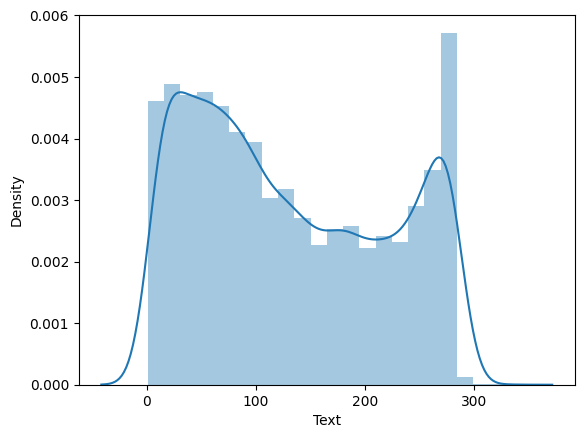

In [19]:
# finding length of tweets
lens = train_data['Text'].str.len()
sns.distplot(lens)

In [20]:
np.median(train_data['Text'].str.len())

115.0

In [21]:
sent_length=115
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  4123 11893 18829  3196  9897
 14875  4781  5171 18311    71  9954 12488]


In [22]:
## Creating a bidirectional LSTM model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 40)           800000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 913,001
Trainable params: 913,001
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
X_lstm=np.array(embedded_docs)
Y_lstm = Y

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X_lstm, Y_lstm, test_size=0.33, random_state=42)

In [27]:
model1.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=25,batch_size=64)

Epoch 1/25
95/95 [==============================] - 42s 436ms/step - loss: -55.9155 - accuracy: 0.7784 - val_loss: -36.2579 - val_accuracy: 0.8082
Epoch 2/25
95/95 [==============================] - 32s 337ms/step - loss: -58.9416 - accuracy: 0.7786 - val_loss: -36.7554 - val_accuracy: 0.8092
Epoch 3/25
95/95 [==============================] - 34s 358ms/step - loss: -61.4474 - accuracy: 0.7771 - val_loss: -39.6951 - val_accuracy: 0.8035
Epoch 4/25
95/95 [==============================] - 33s 341ms/step - loss: -64.3844 - accuracy: 0.7810 - val_loss: -40.8314 - val_accuracy: 0.8025
Epoch 5/25
95/95 [==============================] - 33s 352ms/step - loss: -67.1661 - accuracy: 0.7853 - val_loss: -42.1511 - val_accuracy: 0.8038
Epoch 6/25
95/95 [==============================] - 32s 336ms/step - loss: -69.9734 - accuracy: 0.7842 - val_loss: -41.1454 - val_accuracy: 0.8061
Epoch 7/25
95/95 [==============================] - 34s 362ms/step - loss: -72.6891 - accuracy: 0.7835 - val_loss: -45

In [26]:
y_pred_lstm=model1.predict(x_test)
y_pred_lstm = np.round(abs(y_pred_lstm))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_lstm))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred_lstm))
print(classification_report(y_test,y_pred_lstm))

94/94 [==============================] - 4s 35ms/step
Accuracy Score:  0.8118315508021391
Confusion Matrix: 
 [[2106  149    0    0]
 [  26  323    0    0]
 [  24  280    0    0]
 [  10   74    0    0]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2255
           1       0.39      0.93      0.55       349
           2       0.00      0.00      0.00       304
           3       0.00      0.00      0.00        84

    accuracy                           0.81      2992
   macro avg       0.34      0.46      0.38      2992
weighted avg       0.78      0.81      0.78      2992



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
